PG53624-Ana Filipa da Cunha Rebelo
Visão Por Computador e Processamento de Imagem

Installs Required


In [19]:
%pip install kaggle tqdm pydot


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

# Criar o diretório .kaggle se ele não existir
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Copiar o arquivo kaggle.json para o diretório .kaggle
os.system('cp kaggle.json ~/.kaggle/')

# Definir permissões para o arquivo kaggle.json
os.system('chmod 600 ~/.kaggle/kaggle.json')



0

In [5]:
# Baixar o dataset Pix2Pix Facades
os.system('kaggle datasets download -d sabahesaraki/pix2pix-facades-dataset')

# Descompactar o dataset
os.system('unzip -q pix2pix-facades-dataset.zip -d pix2pix_facades')


/Users/filipa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset URL: https://www.kaggle.com/datasets/sabahesaraki/pix2pix-facades-dataset
License(s): unknown
pix2pix-facades-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


replace pix2pix_facades/facades/test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Imports


In [57]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
from IPython import display



Load Dataset

The dataset was loaded from Kaggle https://www.kaggle.com/datasets/sabahesaraki/pix2pix-facades-dataset 

In [20]:
def load_image(path):
    img = load_img(path)
    img = img_to_array(img) / 255.0
    img = resize(img, (256, 256))
    return img

def load_images(root_path, img_format, trim=None):
    paths = sorted(glob(root_path + f"/*.{img_format}"))
    if trim is not None:
        paths = paths[:trim]
    
    images = []
    masks = []
    
    for path in tqdm(paths, desc='Loading images'):
        img = load_img(path)
        img = img_to_array(img) / 255.0
        
        # Dividir a imagem em imagem normal e máscara
        width = img.shape[1]
        half_width = width // 2
        
        img_normal = img[:, :half_width, :]  # Imagem normal do lado esquerdo
        img_mask = img[:, half_width:, :]    # Máscara do lado direito
        
        images.append(img_normal)
        masks.append(img_mask)
    
    return np.array(images), np.array(masks)

    

train_path = 'pix2pix_facades/facades/train'
train_images, train_masks = load_images(train_path, img_format="jpg", trim=1000)

val_path = 'pix2pix_facades/facades/val'
val_images, val_masks = load_images(val_path, img_format="jpg", trim=100)

test_path = 'pix2pix_facades/facades/test'
test_images, test_masks = load_images(test_path, img_format="jpg", trim=100)

Loading images: 100%|██████████| 100/100 [00:00<00:00, 980.71it/s]


In [3]:
def show_images_and_masks(images, masks, num_images=5):
    indices = np.random.choice(len(images), num_images, replace=False)
    
    for idx in indices:
        image = images[idx]
        mask = masks[idx]
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')
        
        plt.show()

# Exemplo de uso para visualizar imagens de treino
show_images_and_masks(train_images, train_masks)

NameError: name 'train_images' is not defined

Pre-Processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


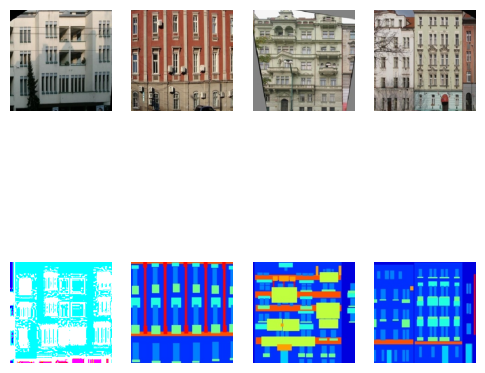

In [59]:

BUFFER_SIZE = 606
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256


# Define transformations
resize = transforms.Resize((286, 286))
random_crop = transforms.RandomCrop((IMG_HEIGHT, IMG_WIDTH))
normalize = transforms.Normalize((0.5,), (0.5,))
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)

def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image = resize(input_image)
    real_image = resize(real_image)

    # Random cropping back to 256x256
    input_image = random_crop(input_image)
    real_image = random_crop(real_image)

    # Random mirroring
    if torch.rand(1) > 0.5:
        input_image = horizontal_flip(input_image)
        real_image = horizontal_flip(real_image)

    # Normalizing
    input_image = normalize(input_image)
    real_image = normalize(real_image)

    return input_image, real_image

def show_random_jitter_examples(images, masks, random_jitter_fn, num_examples=4):
    plt.figure(figsize=(6, 6))
    for i in range(num_examples):
        rj_inp, rj_re = random_jitter_fn(images[i], masks[i])
        rj_inp = rj_inp.permute(1, 2, 0)  # Convert to HWC for plotting
        rj_re = rj_re.permute(1, 2, 0)    # Convert to HWC for plotting
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(rj_inp)
        plt.axis('off')
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(rj_re)
        plt.axis('off')

    plt.show()

# Assuming train_images and train_masks are already loaded and are torch tensors
show_random_jitter_examples(train_images, train_masks, random_jitter, num_examples=4)

Build an input pipeline


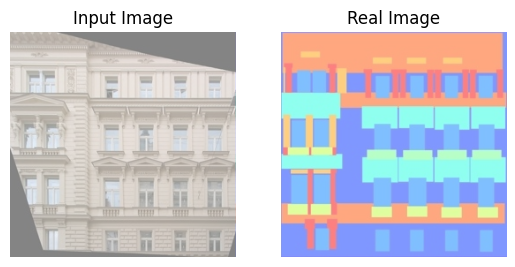

2024-06-22 18:23:58.007362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [100]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.batch(BATCH_SIZE)




# Exemplo de iteração pelo dataset
for input_image, real_image in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow((input_image[0] + 1) / 2)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow((real_image[0] + 1) / 2)
    plt.title('Real Image')
    plt.axis('off')
    
    plt.show()

Generator 


In [101]:
OUTPUT_CHANNELS = 3

In [102]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(train_masks[0], 0))
print (down_result.shape)

(1, 128, 128, 3)


In [103]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [104]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

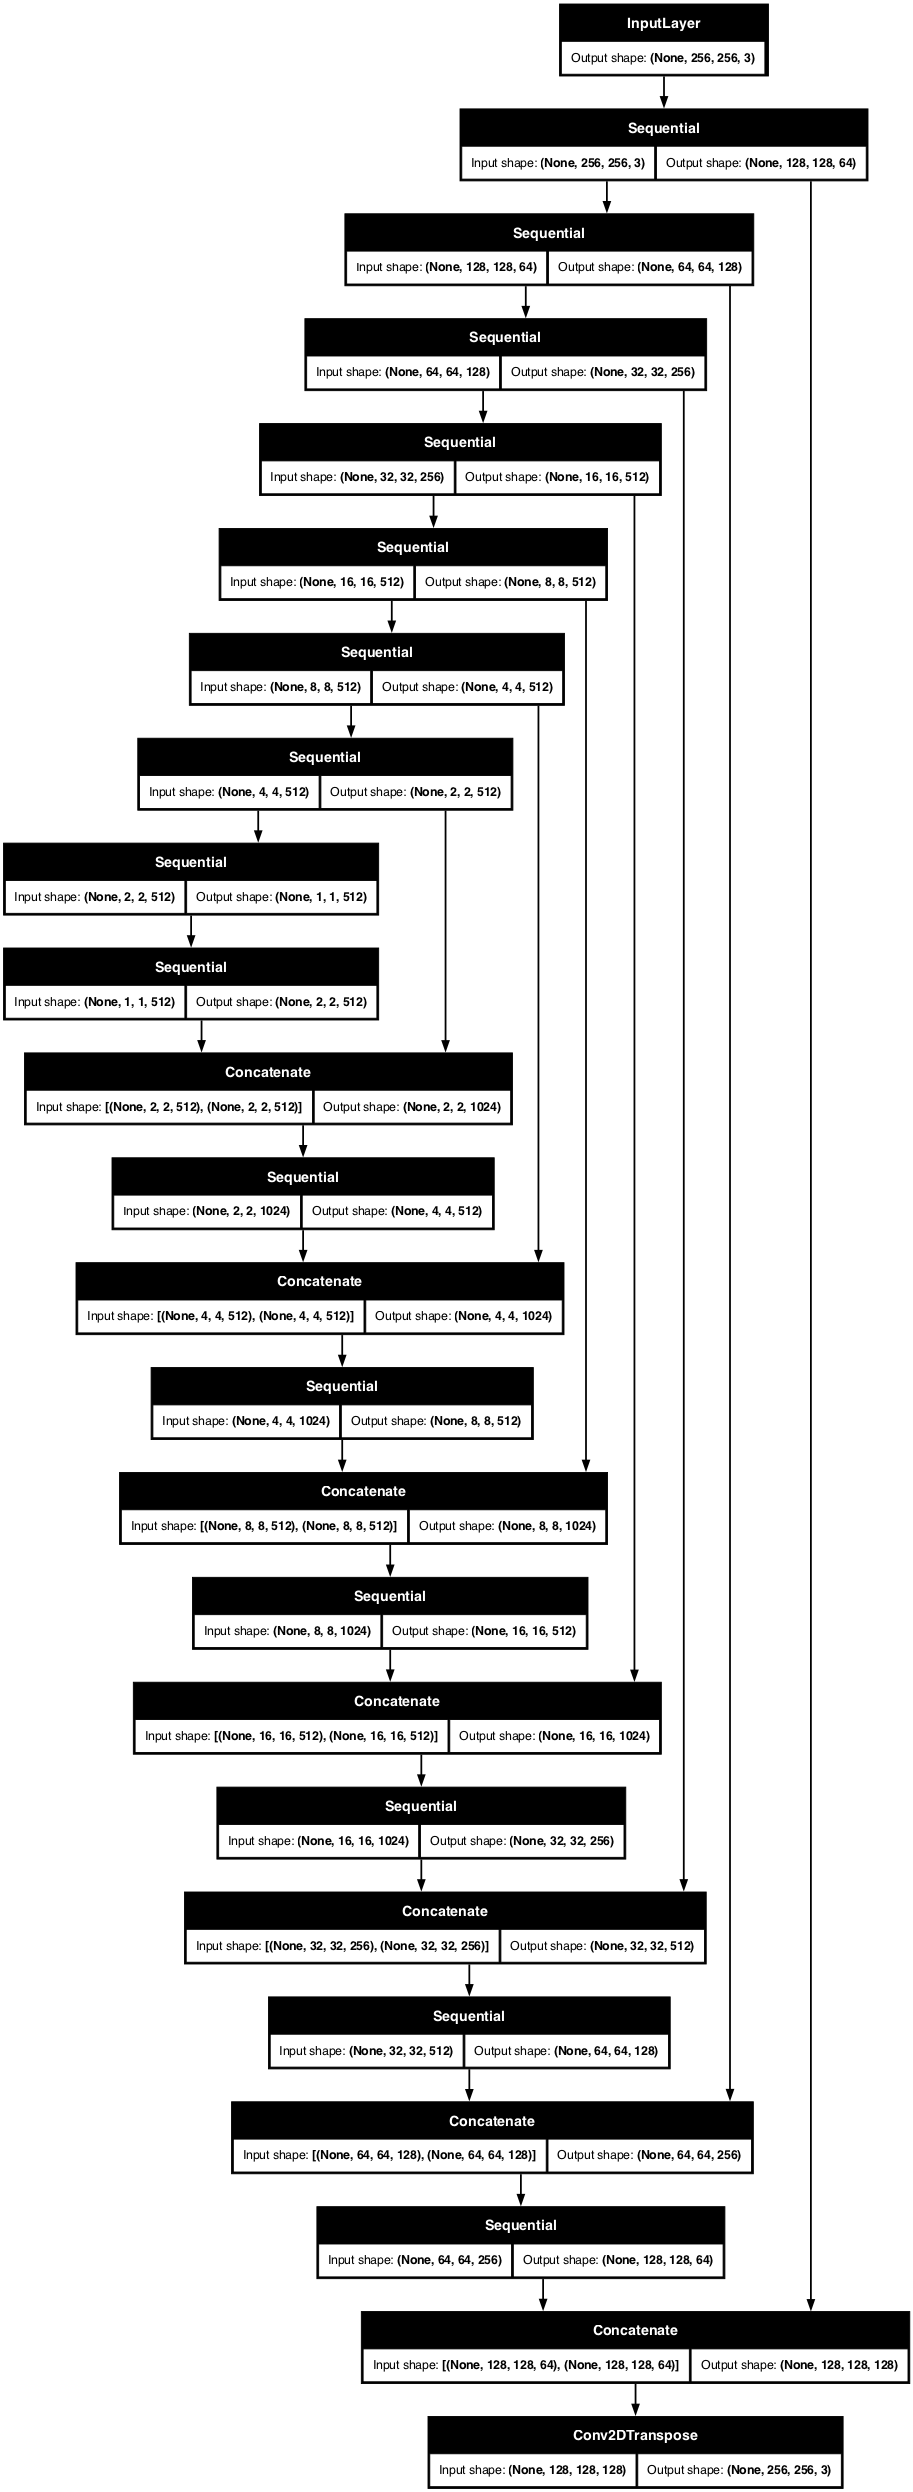

In [105]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

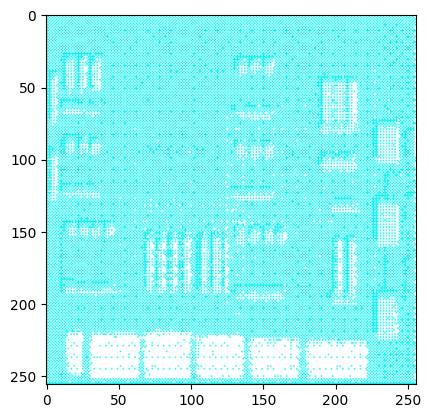

In [121]:
train_masks[0] = train_masks[0] * 255.0
gen_output = generator(train_masks[0][tf.newaxis, ...], training=False)

# Check the range of gen_output and normalize if necessary
if tf.reduce_max(gen_output) > 1.0:
    # Normalize to [0, 1] if the max value is greater than 1
    gen_output = gen_output / 255.0

# Ensure the output is in the range [0, 1]
gen_output = tf.clip_by_value(gen_output, 0.0, 1.0)

# Plot the generated output
plt.imshow(gen_output[0, ...])
plt.show()

Loss Functions

In [107]:
LAMBDA = 100

In [108]:
loss_object = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

In [109]:

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

# Cast target to the same data type as gen_output
  target = tf.cast(target, tf.float32)
  
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [110]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

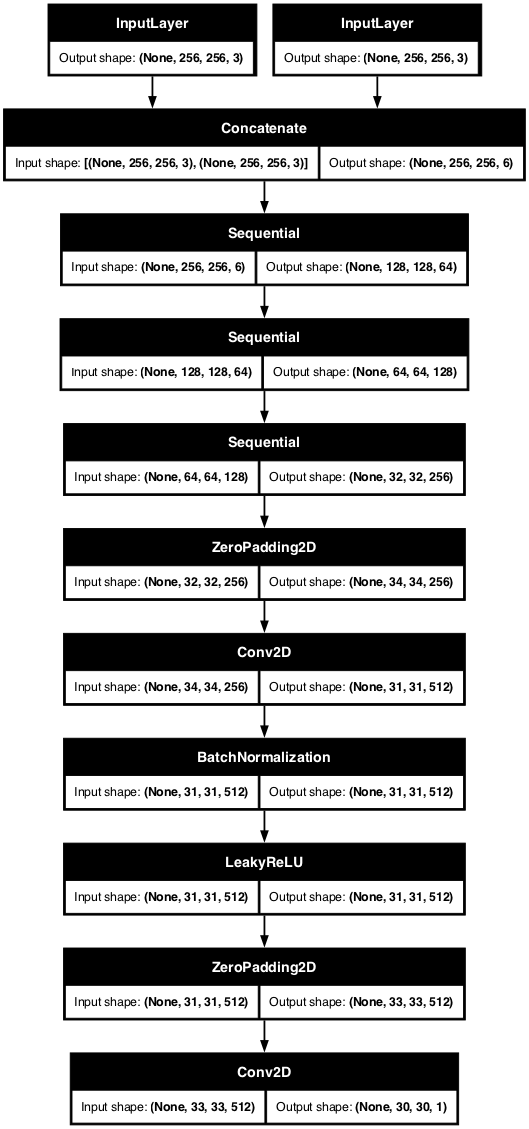

In [111]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

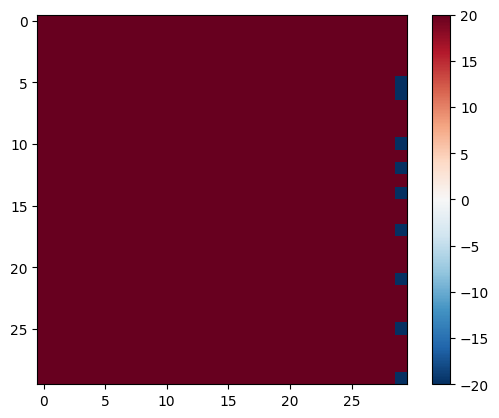

In [112]:
mask_tensor = tf.convert_to_tensor(train_masks[0][tf.newaxis, ...], dtype=tf.float32)


gen_output_tensor = tf.convert_to_tensor(gen_output, dtype=tf.float32)
disc_out = discriminator([mask_tensor, gen_output_tensor], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


In [113]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Define the optimizers and a checkpoint-saver

In [114]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Generate Images


In [115]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

test the function

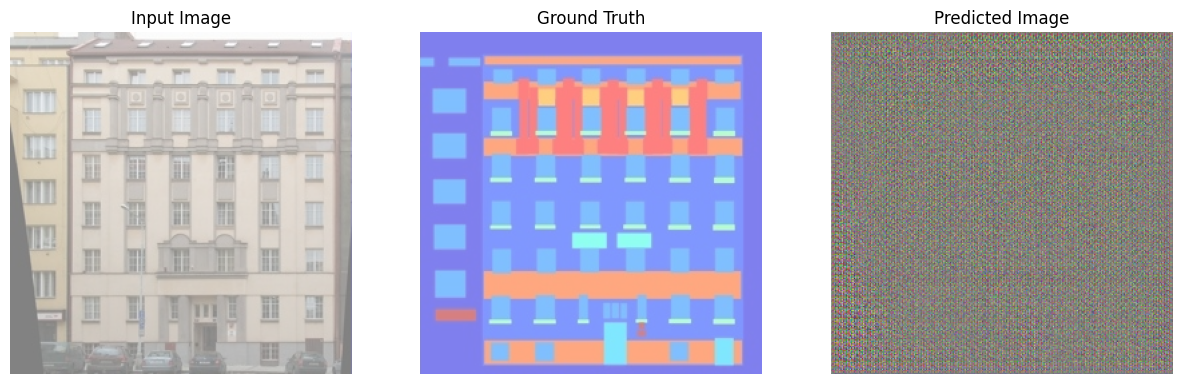

2024-06-22 18:24:43.140963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [116]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

Training


In [117]:
import datetime


log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [118]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [119]:
import time


def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

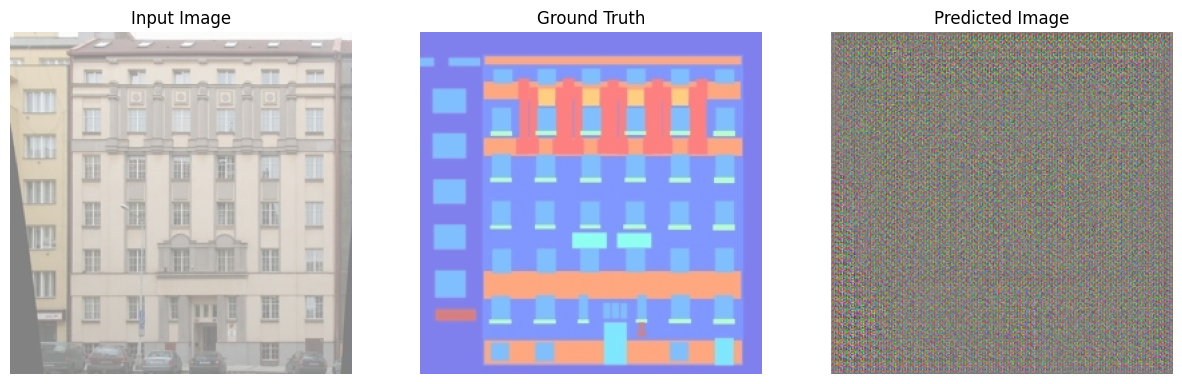

Step: 0k
...

KeyboardInterrupt: 

In [120]:
fit(train_dataset, test_dataset, steps=40000)

In [53]:
## Restore the latest checkpoint and test the network

!ls {checkpoint_dir}

ls: ./training_checkpoints: No such file or directory


In [54]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Generate some images using the test set

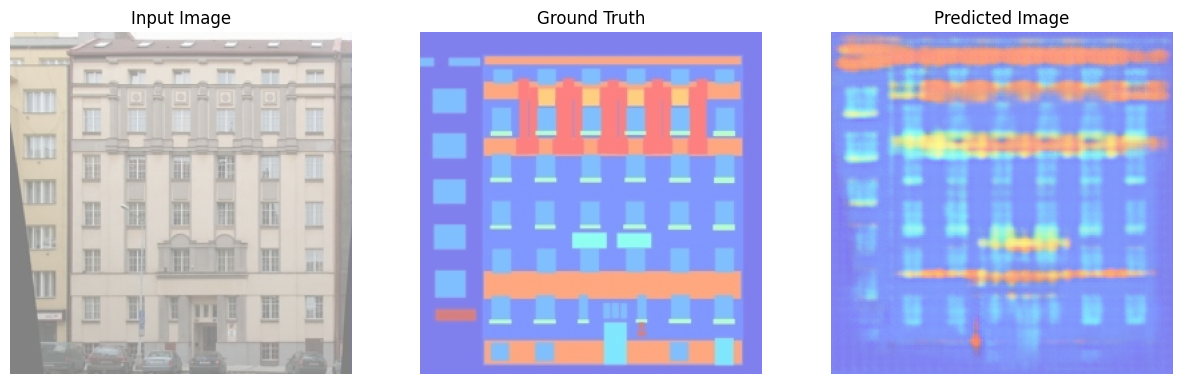

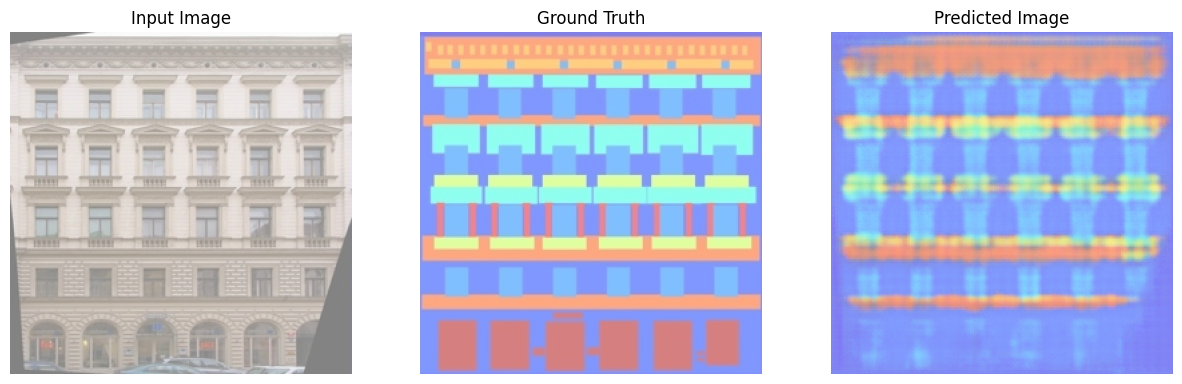

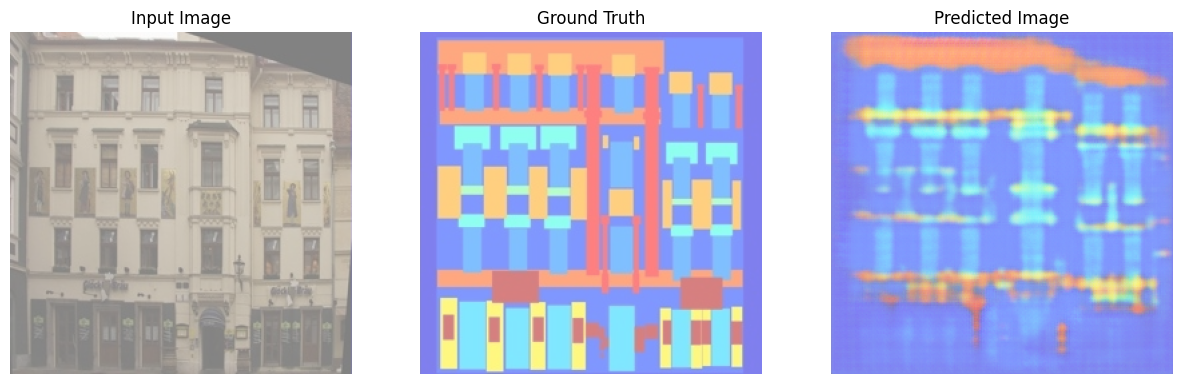

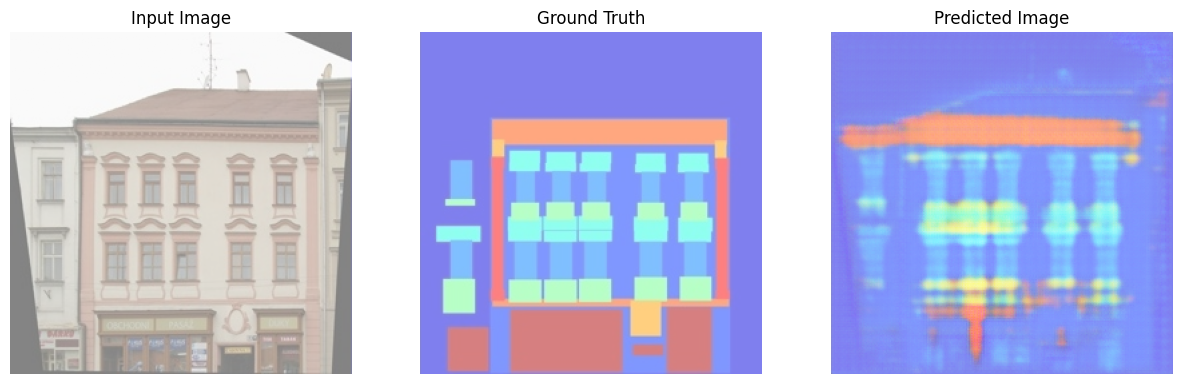

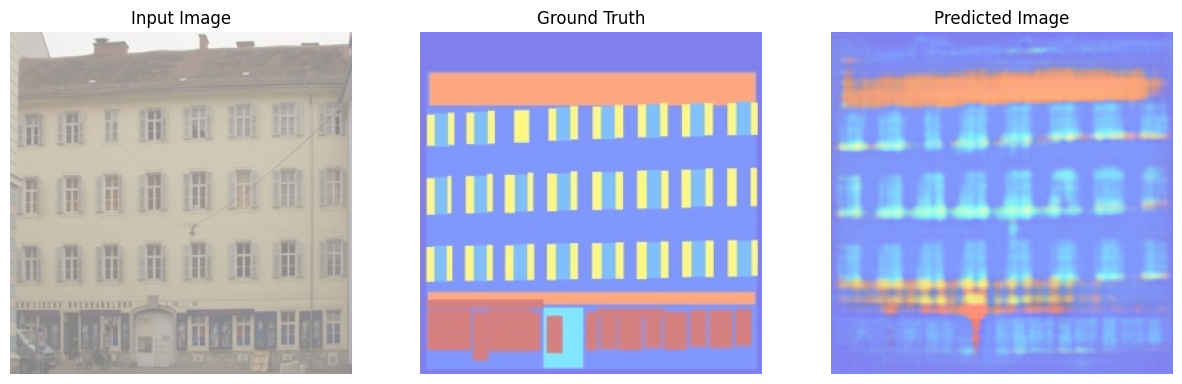

2024-06-22 18:07:23.842374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [55]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)